<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAMed_Endonasal_LoRA2_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customized Segment Anything Model for Medical Image Segmentation
### [[Paper](https://arxiv.org/pdf/2304.13785.pdf)] [[Github](https://github.com/hitachinsk/SAMed)]
---


# Setup environment

In [1]:
!pip install -q gdown==4.6.0 einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: deprecated, use  4.5.4.60
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:0

# Download codes, pretrained weights and test data

In [2]:
# prepare codes
import os
CODE_DIR = 'samed_codes'
os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/hitachinsk/SAMed.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'samed_codes'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 225 (delta 42), reused 29 (delta 29), pack-reused 167 (from 1)
Receiving objects: 100% (225/225), 636.92 KiB | 2.31 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [3]:
!gdown 1g_Hb28K0wsfKyUGdgNnPNfrmSAAXYl5L
!gdown 1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
!gdown 1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg

Downloading...
From: https://drive.google.com/uc?id=1g_Hb28K0wsfKyUGdgNnPNfrmSAAXYl5L
To: /content/samed_codes/Endonasal_Slices_Voxel.zip
100% 138M/138M [00:04<00:00, 32.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
To: /content/samed_codes/epoch_159.pth
100% 19.7M/19.7M [00:01<00:00, 18.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
To: /content/samed_codes/sam_vit_b_01ec64.pth
100% 375M/375M [00:08<00:00, 42.5MB/s]


In [4]:
!unzip -q Endonasal_Slices_Voxel.zip

Dataloader:

/content
Train Sample: 798 Test Sample: 342


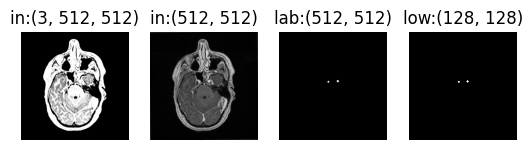

In [8]:
%cd /content/samed_codes
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio.v2 as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.ndimage import zoom
from einops import repeat
from scipy import ndimage
import random
from PIL import Image
import cv2

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

class EndonasalDataset(Dataset):
    def __init__(self, root='endonasal_train', low_res=None, isTrain=False):
        self.img_path_all = glob(root + '/mri_t1c/*.png')  # Update the path and pattern
        self.mask_path_all = glob(root + '/mri_masks/*.png')  # Update the path and pattern
        self.isTrain = isTrain
        self.isTrain = isTrain
        self.low_res = low_res

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        image = iio.imread(self.img_path_all[index])
        image = normalise_intensity(image)
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)
        label = iio.imread(self.mask_path_all[index])
        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)
        if self.isTrain:
            if random.random() > 0.5:
                image, label = random_rot_flip(image, label)
            elif random.random() > 0.5:
                image, label = random_rotate(image, label)

        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label}

        return sample

train_dataset = EndonasalDataset(root='Endonasal_Slices_Voxel/Train', low_res=128, isTrain=True)
test_dataset = EndonasalDataset(root='Endonasal_Slices_Voxel/Test', low_res=128)
print('Train Sample:', len(train_dataset), 'Test Sample:', len(test_dataset))
sample = train_dataset[10]
input, label, low_res_label = np.array(sample['image']), sample['label'], sample['low_res_label']
plt.subplot(1,4,1), plt.axis('OFF'), plt.title('in:{}'.format(input.shape)), plt.imshow(input.transpose(1,2,0))
plt.subplot(1,4,2), plt.axis('OFF'), plt.title('in:{}'.format(input[0].shape)), plt.imshow(input[0], cmap='gray')
plt.subplot(1,4,3), plt.axis('OFF'), plt.title('lab:{}'.format(label.shape)), plt.imshow(label, cmap='gray');
plt.subplot(1,4,4), plt.axis('OFF'), plt.title('low:{}'.format(low_res_label.shape)), plt.imshow(low_res_label, cmap='gray');

In [9]:
from segment_anything import build_sam, SamPredictor
from segment_anything import sam_model_registry

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
from segment_anything.modeling import Sam
from safetensors import safe_open
from safetensors.torch import save_file

from icecream import ic

class _LoRA_qkv_v0_v2(nn.Module):

    def __init__(
            self,
            qkv: nn.Module,
            linear_a_q: nn.Module,
            linear_b_q: nn.Module,
            linear_a_v: nn.Module,
            linear_b_v: nn.Module,
            conv_se_q: nn.Module,
            conv_se_v: nn.Module,
    ):
        super().__init__()
        self.qkv = qkv
        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q
        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v
        self.conv_se_q = conv_se_q
        self.conv_se_v = conv_se_v

        self.dim = qkv.in_features
        self.w_identity = torch.eye(qkv.in_features)

    def forward(self, x):
        qkv = self.qkv(x)
        a_q_out = self.linear_a_q(x)
        a_v_out = self.linear_a_v(x)
        a_q_out_temp = self.conv_se_q(a_q_out.permute(0,3,1,2)).permute(0,2,3,1)
        a_v_out_temp = self.conv_se_v(a_v_out.permute(0,3,1,2)).permute(0,2,3,1)

        new_q = self.linear_b_q(torch.mul(a_q_out, torch.sigmoid(a_q_out_temp)))#SE = Squeeze and Excitation
        new_v = self.linear_b_v(torch.mul(a_v_out, torch.sigmoid(a_v_out_temp)))

        qkv[:, :, :, : self.dim] += new_q
        qkv[:, :, :, -self.dim:] += new_v
        return qkv

class LoRA_Sam_v0_v2(nn.Module):

    def __init__(self, sam_model: Sam, r: int, lora_layer=None):
        super(LoRA_Sam_v0_v2, self).__init__()

        assert r > 0
        if lora_layer:
            self.lora_layer = lora_layer
        else:
            self.lora_layer = list(
                range(len(sam_model.image_encoder.blocks)))  # Only apply lora to the image encoder by default
        # create for storage, then we can init them or load weights
        self.w_As = []  # These are linear layers
        self.w_Bs = []

        # lets freeze first
        for param in sam_model.image_encoder.parameters():
            param.requires_grad = False

        # Here, we do the surgery
        for t_layer_i, blk in enumerate(sam_model.image_encoder.blocks):
            # If we only want few lora layer instead of all
            if t_layer_i not in self.lora_layer:
                continue
            w_qkv_linear = blk.attn.qkv
            self.dim = w_qkv_linear.in_features
            w_a_linear_q = nn.Linear(self.dim, r, bias=False)
            w_b_linear_q = nn.Linear(r, self.dim, bias=False)
            w_a_linear_v = nn.Linear(self.dim, r, bias=False)
            w_b_linear_v = nn.Linear(r, self.dim, bias=False)

            conv_se_q = nn.Conv2d(r, r, kernel_size=1,
                                    stride=1, padding=0, bias=False)
            conv_se_v = nn.Conv2d(r, r, kernel_size=1,
                                    stride=1, padding=0, bias=False)
            self.w_As.append(w_a_linear_q)
            self.w_Bs.append(w_b_linear_q)
            self.w_As.append(w_a_linear_v)
            self.w_Bs.append(w_b_linear_v)
            self.w_As.append(conv_se_q)
            self.w_As.append(conv_se_v)
            blk.attn.qkv = _LoRA_qkv_v0_v2(
                w_qkv_linear,
                w_a_linear_q,
                w_b_linear_q,
                w_a_linear_v,
                w_b_linear_v,
                conv_se_q,
                conv_se_v,
            )
        self.reset_parameters()
        self.sam = sam_model

    def save_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.

        save both lora and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        num_layer = len(self.w_As)  # actually, it is half
        a_tensors = {f"w_a_{i:03d}": self.w_As[i].weight for i in range(num_layer)}
        b_tensors = {f"w_b_{i:03d}": self.w_Bs[i].weight for i in range(num_layer)}
        prompt_encoder_tensors = {}
        mask_decoder_tensors = {}

        # save prompt encoder, only `state_dict`, the `named_parameter` is not permitted
        if isinstance(self.sam, torch.nn.DataParallel) or isinstance(self.sam, torch.nn.parallel.DistributedDataParallel):
            state_dict = self.sam.module.state_dict()
        else:
            state_dict = self.sam.state_dict()
        for key, value in state_dict.items():
            if 'prompt_encoder' in key:
                prompt_encoder_tensors[key] = value
            if 'mask_decoder' in key:
                mask_decoder_tensors[key] = value

        merged_dict = {**a_tensors, **b_tensors, **prompt_encoder_tensors, **mask_decoder_tensors}
        torch.save(merged_dict, filename)

    def load_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.\

        load both lora and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        state_dict = torch.load(filename)

        for i, w_A_linear in enumerate(self.w_As):
            saved_key = f"w_a_{i:03d}"
            # print('mobarak:', saved_key)
            saved_tensor = state_dict[saved_key]
            w_A_linear.weight = Parameter(saved_tensor)

        for i, w_B_linear in enumerate(self.w_Bs):
            saved_key = f"w_b_{i:03d}"
            saved_tensor = state_dict[saved_key]
            w_B_linear.weight = Parameter(saved_tensor)

        sam_dict = self.sam.state_dict()
        sam_keys = sam_dict.keys()

        # load prompt encoder
        prompt_encoder_keys = [k for k in sam_keys if 'prompt_encoder' in k]
        prompt_encoder_values = [state_dict[k] for k in prompt_encoder_keys]
        prompt_encoder_new_state_dict = {k: v for k, v in zip(prompt_encoder_keys, prompt_encoder_values)}
        sam_dict.update(prompt_encoder_new_state_dict)

        # load mask decoder
        mask_decoder_keys = [k for k in sam_keys if 'mask_decoder' in k]
        mask_decoder_values = [state_dict[k] for k in mask_decoder_keys]
        mask_decoder_new_state_dict = {k: v for k, v in zip(mask_decoder_keys, mask_decoder_values)}
        sam_dict.update(mask_decoder_new_state_dict)
        self.sam.load_state_dict(sam_dict)

    def reset_parameters(self) -> None:
        for w_A in self.w_As:
            nn.init.kaiming_uniform_(w_A.weight, a=math.sqrt(5))
        for w_B in self.w_Bs:
            nn.init.zeros_(w_B.weight)

    def forward(self, batched_input, multimask_output, image_size):
        return self.sam(batched_input, multimask_output, image_size)

Network Training Parameter:

SAM Training

In [ ]:
%cd /content/samed_codes
import os
import cv2

import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

from torch.nn.modules.loss import CrossEntropyLoss
from utils import DiceLoss
import torch.optim as optim
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

def adjust_learning_rate(optimizer, iter_num, args):
    if args.warmup and iter_num < args.warmup_period:
        lr_ = args.base_lr * ((iter_num + 1) / args.warmup_period)
    else:
        if args.warmup:
            shift_iter = iter_num - args.warmup_period
            assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
        else:
            shift_iter = iter_num
        lr_ = args.base_lr * (1.0 - shift_iter / args.max_iterations) ** 0.9
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_
    return lr_

def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def inference_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    # fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch, multimask_output, args.img_size)
            logits = outputs['masks']
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(logits, label_batch, ce_loss, dice_loss, args)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            low_res_logits = outputs['low_res_logits']
            loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
            img_num = 0
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class
def seed_everything(seed=42):
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def calc_loss(output, label_batch, ce_loss, dice_loss, args):
    loss_ce = ce_loss(output, label_batch[:].long())
    loss_dice = dice_loss(output, label_batch, softmax=True)
    loss = (1 - args.dice_weight) * loss_ce + args.dice_weight * loss_dice
    return loss, loss_ce, loss_dice


def training_per_epoch(model, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=True, args=None):
    model.train()
    loss_all = []

    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
        image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
        batch_dict = {'image_batch':label_batch, 'label_batch':label_batch, 'low_res_label_batch':low_res_label_batch}
        outputs = model(image_batch, multimask_output, args.img_size)
        output = outputs[args.output_key]
        loss_label_batch = batch_dict[args.batch_key]
        loss, loss_ce, loss_dice = calc_loss(output, loss_label_batch, ce_loss, dice_loss, args)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        # Update learning rate and increment iteration count
        lr_current = adjust_learning_rate(optimizer, iter_num, args)
        iter_num += 1

        loss_all.append(loss.item())


    return np.mean(loss_all), iter_num, lr_current


def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    loss_per_epoch, dice_per_epoch = [], []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            batch_dict = {'image_batch':label_batch, 'label_batch':label_batch, 'low_res_label_batch':low_res_label_batch}
            outputs = model(image_batch, multimask_output, args.img_size)
            output = outputs[args.output_key]
            loss_label_batch = batch_dict[args.batch_key]
            loss, loss_ce, loss_dice = calc_loss(output, loss_label_batch, ce_loss, dice_loss, args)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
    return np.mean(loss_per_epoch), np.mean(dice_per_epoch)



def main():
    parser = argparse.ArgumentParser()
    # Add new arguments
    parser.add_argument('--batch_key', type=str, default='low_res_label_batch', help='Key for accessing label batch')
    parser.add_argument('--output_key', type=str, default='low_res_logits', help='Key for accessing model outputs')

    parser.add_argument('--dice_weight', type=float, default=0.8, help='Weight for dice loss in the loss calculation')
    parser.add_argument('--weights', type=int, nargs='+', default=None,
                    help='List of weights for each class. Provide space-separated values.')

    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--data_path', type=str, default='Endonasal_Slices_Voxel')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--output_file', type=str, default='Endo_best.pt')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=6, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.0005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=10, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.output_dir = 'results'
    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'results/' + args.output_file
    os.makedirs(args.output_dir, exist_ok = True)

    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    # pkg = import_module(args.module)
    net = LoRA_Sam_v0_v2(sam, args.rank).cuda()
    # net.load_lora_parameters(args.lora_ckpt)
    multimask_output = True if args.num_classes > 1 else False
    train_dataset = EndonasalDataset(root=(args.data_path+'/Train'), low_res=128, isTrain=True)
    test_dataset = EndonasalDataset(root=(args.data_path+'/Test'), low_res=128)
    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset), 'batch:', args.batch_size)

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)
    b_lr = args.base_lr / args.warmup_period
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    iter_num = 0

    best_epoch, best_loss = 0.0, np.inf
    for epoch in range(args.max_epochs):
        loss_training, iter_num, lr_current = training_per_epoch(net, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=multimask_output, args=args)
        loss_testing, dice = test_per_epoch(net, testloader, ce_loss, dice_loss,multimask_output=True, args=args)

        if loss_testing < best_loss:
            best_loss = loss_testing
            best_epoch = epoch
            net.save_lora_parameters(os.path.join(args.output_dir, args.output_file))

        print('--- Epoch {}/{}: Training loss = {:.4f}, Testing: [loss = {:.4f}, dice = {:.4f}], Best loss = {:.4f}, Best epoch = {}, lr = {:.6f}'.\
    format(epoch, args.max_epochs, loss_training, loss_testing, dice, best_loss, best_epoch, lr_current))

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)
    testloader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)
    test_loss, overall_dice, dices_per_class = inference_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
    dices_per_class_list = np.array(list(dices_per_class.values()))
    print('Class Wise Dice:', dices_per_class)
    print('Overall Dice:', np.mean(dices_per_class_list))

if __name__ == '__main__':
    seed_everything()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    main()



/content


/content/samed_codes/segment_anything/build_sam.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Training on: cuda train sample size: 798 test sample size: 342 batch: 10


Inference: My Dice Metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch, multimask_output, args.img_size)
            logits = outputs['masks']
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            low_res_logits = outputs['low_res_logits']
            loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
            img_num = 0
            axs[i_batch, 0].imshow(image_batch[img_num, 0].cpu().numpy(), cmap='gray')
            axs[i_batch, 1].imshow(label_batch[img_num].cpu().numpy(), cmap='gray')
            axs[i_batch, 2].imshow(pred_seg[img_num].cpu().numpy(), cmap='gray')
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class



if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=12, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'results/model_best.pt'
    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    net = LoRA_Sam_v0_v2(sam, args.rank).cuda()
    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)
    testloader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)
    test_loss, overall_dice, dices_per_class = test_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
    dices_per_class_list = np.array(list(dices_per_class.values()))
    print('Class Wise Dice:', dices_per_class)
    print('Overall Dice:', np.mean(dices_per_class_list))

Inference MRI to MRI<br>
download test mri

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1zcvnBscFVI2v5ieAlGGnp0zpX8WmIrD4'
gdown.download(url,'endonasal_mri_patients.zip',quiet=True)
!unzip -q endonasal_mri_patients
!rm -rf /content/endonasal_mri_patients/.DS_Store
!rm -rf /content/endonasal_mri_patients/**/.DS_Store

MRI to MRI

In [ ]:
import os
import nibabel as nib
import cv2
import numpy as np
from scipy.ndimage import zoom
from einops import repeat
import random
import matplotlib.pyplot as plt
import numpy as np

def read_mri(mri_path):
    img_meta = nib.load(mri_path)
    array = img_meta.get_fdata()
    return np.rot90(array)

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

class EndonasalDataset_MRI(Dataset):
    def __init__(self, root='endonasal_mri_patients', patient=None, low_res=None, isTrain=False):

        mri_path = 'endonasal_mri_patients/mri0{}/mri0{}_t1c.nii.gz'.format(patient, patient)
        self.mask_path = 'endonasal_mri_patients/mri0{}/mri0{}_mask.nii.gz'.format(patient, patient)
        mri_array = read_mri(mri_path)
        self.image_all = []
        for z in range(mri_array.shape[2]):
            normalized_slice = cv2.normalize(mri_array[:, :, z], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            self.image_all.append(normalise_intensity(normalized_slice))

        self.mask_all = read_mri(self.mask_path)
        self.isTrain = isTrain
        self.low_res = low_res

    def __len__(self):
      return len(self.image_all)

    def __getitem__(self, index):
        image = self.image_all[index]
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)
        label = self.mask_all[:,:,index]
        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)
        if self.isTrain:
            if random.random() > 0.5:
                image, label = random_rot_flip(image, label)
            elif random.random() > 0.5:
                image, label = random_rotate(image, label)

        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label, 'maskpath': self.mask_path}

        return sample


def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def pred_to_mri(pred_seg_all, mask_path):
    os.makedirs('predicted_mri', mode = 0o777, exist_ok = True)
    img_meta = nib.load(mask_path)
    pred_seg_all = np.rot90(np.array(pred_seg_all).transpose(1,2,0), k=-1)
    img_nifti = nib.Nifti1Image(pred_seg_all, img_meta.affine, header=img_meta.header)
    nib.save(img_nifti,'predicted_mri/'+os.path.basename(mask_path))

def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    pred_seg_all = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch, multimask_output, args.img_size)
            logits = outputs['masks']
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            pred_seg_all.extend(pred_seg.detach().cpu().numpy())
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            low_res_logits = outputs['low_res_logits']
            loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        pred_to_mri(np.array(pred_seg_all), sampled_batch['maskpath'][0])
        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): round(dice, 4)
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class



if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=12, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'results/model_best.pt'
    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    net = LoRA_Sam_v0_v2(sam, args.rank).cuda()
    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)

    patients = ['154', '169', '170']
    mean_overall = []
    tumor_overall = []
    carotid_overall = []
    for patient in patients:
        test_dataset = EndonasalDataset_MRI(root='endonasal_mri_patients', patient=patient, low_res=128)
        testloader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)
        test_loss, overall_dice, dices_per_class = test_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
        dices_per_class_list = np.array(list(dices_per_class.values()))
        overall = round(np.mean(dices_per_class_list),4)
        mean_overall.append(overall)
        tumor_overall.append(dices_per_class['dice_cls:1'])
        carotid_overall.append(dices_per_class['dice_cls:2'])
        print('Patient:', patient, ',Class Wise:', dices_per_class, ',Overall :', overall)

    print('Overall Model Performance [Mean Overall]:', round(np.mean(mean_overall),4), '[cls-1:{}]'.format(round(np.mean(tumor_overall),4)),\
            '[cls-2:{}]'.format(round(np.mean(carotid_overall),4)))


Patient: 154 ,Class Wise: {'dice_cls:1': 0.9737, 'dice_cls:2': 0.7039} ,Overall : 0.8388
Patient: 169 ,Class Wise: {'dice_cls:1': 0.991, 'dice_cls:2': 0.9621} ,Overall : 0.9766
Patient: 170 ,Class Wise: {'dice_cls:1': 0.9894, 'dice_cls:2': 0.8928} ,Overall : 0.9411
Overall Model Performance [Mean Overall]: 0.9188 [cls-1:0.9847] [cls-2:0.8529]


Post Processing to remove outliers (small seg)

In [ ]:
from skimage import morphology
import nibabel as nib
mask_meta = nib.load('/content/samed_codes/endonasal_mri_patients/mri0169/mri0169_mask.nii.gz')
mask = nib.load('/content/samed_codes/predicted_mri/mri0169_mask.nii.gz').get_fdata()

binary_mask = morphology.remove_small_objects(mask>0, 50)
mask[binary_mask==0] = 0
img_nifti = nib.Nifti1Image(mask, mask_meta.affine, header=mask_meta.header)
nib.save(img_nifti,'mri0169_mask_post_processed.nii.gz')